In [163]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error

df = pd.read_csv ("~/Desktop/heart_failure_clinical_records_dataset.csv")
df.head()




,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


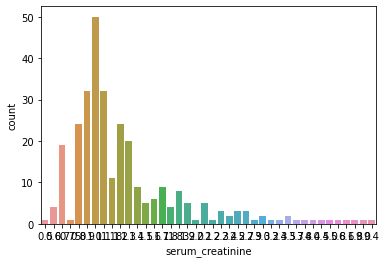

In [164]:
sns.countplot(x = 'serum_creatinine', data=df)
#sns.histplot(data=df, x="pressureLevel") #for continuous values
plt.show()




<AxesSubplot:xlabel='serum_creatinine', ylabel='Count'>

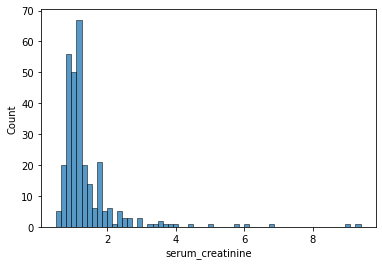

In [165]:
sns.histplot(data=df, x="serum_creatinine") #for continuous values

In [436]:
#input
all_X = df.drop(df.columns[[-1]],axis=1)
#output
all_Y = df.iloc[:,7]

In [437]:
#Split using numpy.  Stratify lets us evenly distribute the above (uneven) categories.
trainval_x, test_x, trainval_y, test_y = train_test_split(all_X, all_Y, 
                                                    test_size=0.2,
                                                    random_state=69)

train_x, x_val, train_y, y_val = train_test_split(trainval_x, trainval_y,
                                                  test_size=0.1,
                                                  random_state=21)

In [438]:
#MinMaxScale - get everything on a scale from 0-1.
scaler = MinMaxScaler()

train_x = scaler.fit_transform(train_x)
x_val = scaler.transform(x_val)
test_x = scaler.transform(test_x)

train_x, train_y = np.array(train_x), np.array(train_y)
x_val, y_val = np.array(x_val), np.array(y_val)
test_x, test_y = np.array(test_x), np.array(test_y)


In [439]:
#distribute evenly.
def get_class_distribution(obj):
    count_dict = {
        "length_254": 0,
        "length_508": 0,
        "length_1016": 0,
        "length_1524": 0,
        "length_2286": 0,
        "length_3058": 0,
    }
    
    for i in obj:
        if i == 0.0254: 
            count_dict['length_254'] += 1
        elif i == 0.0508: 
            count_dict['length_508'] += 1
        elif i == 0.1016: 
            count_dict['length_1016'] += 1
        elif i == 0.1524: 
            count_dict['length_1524'] += 1
        elif i == 0.2286: 
            count_dict['length_2286'] += 1  
        elif i == 0.3058: 
            count_dict['length_3058'] += 1              
        else:
            print("Something doesn't match! Error state.")
            
    return count_dict

In [440]:
#Convert to a float (don't... know why.)
train_y, test_y, y_val = train_y.astype(float), test_y.astype(float), y_val.astype(float)

In [441]:
#Initialize dataset
class RegressionDataset(Dataset):
    
    def __init__(self, data_x, data_y):
        self.data_x = data_x
        self.data_y = data_y
        
    def __getitem__(self, index):
        return self.data_x[index], self.data_y[index]
    
    def __len__(self):
        return len(self.data_x)
    
train_dataset = RegressionDataset(torch.from_numpy(train_x).float(),
                                 torch.from_numpy(train_y).float())

val_dataset = RegressionDataset(torch.from_numpy(x_val).float(),
                                 torch.from_numpy(y_val).float())

test_dataset = RegressionDataset(torch.from_numpy(test_x).float(),
                                 torch.from_numpy(test_y).float())

In [442]:
#Model Parameters
EPOCHS = 200
BATCH_SIZE = 500
LEARNING_RATE = 0.1
NUM_FEATURES = len(all_X.columns)

In [443]:
#Initialize the dataloader
train_loader = DataLoader(dataset=train_dataset,
                          batch_size = BATCH_SIZE, shuffle=True)

val_loader = DataLoader(dataset=val_dataset, batch_size=1)

test_loader = DataLoader(dataset=test_dataset, batch_size=1)



In [444]:
#Define the Neural Network Architecture.  
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 5)
        self.layer_2 = nn.Linear(5, 10)
        self.layer_3 = nn.Linear(10, 10)
        self.layer_out = nn.Linear(10,1)
        
        self.relu = nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        
        return(x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        
        return(x)



In [445]:
#Check for a GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [446]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)

print(model)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=12, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_out): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [447]:
#A dictionary to store our loss and epoch
loss_stats = {
    'train': [],
    'val': []
}

In [448]:
print("Begin training.")

for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    
    model.train()
    for train_x_batch, train_y_batch in train_loader:
        train_x_batch, train_y_batch = train_x_batch.to(device), train_y_batch.to(device)
        optimizer.zero_grad()
        
        train_y_pred = model(train_x_batch)
        
        train_loss = criterion(train_y_pred, train_y_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
    #VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0
        
        model.eval()
        for x_val_batch, y_val_batch in val_loader:
            x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(x_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
    
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
        

Begin training.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 3.70744 | Val Loss: 2.53717
Epoch 002: | Train Loss: 2.12632 | Val Loss: 1.40144
Epoch 003: | Train Loss: 1.15974 | Val Loss: 2.08029
Epoch 004: | Train Loss: 1.95959 | Val Loss: 1.33044
Epoch 005: | Train Loss: 1.09175 | Val Loss: 1.56435
Epoch 006: | Train Loss: 1.26902 | Val Loss: 1.72656
Epoch 007: | Train Loss: 1.41578 | Val Loss: 1.73038
Epoch 008: | Train Loss: 1.42286 | Val Loss: 1.63705
Epoch 009: | Train Loss: 1.34399 | Val Loss: 1.49785
Epoch 010: | Train Loss: 1.22762 | Val Loss: 1.35670
Epoch 011: | Train Loss: 1.11643 | Val Loss: 1.25893
Epoch 012: | Train Loss: 1.05386 | Val Loss: 1.23799
Epoch 013: | Train Loss: 1.06886 | Val Loss: 1.27504
Epoch 014: | Train Loss: 1.13436 | Val Loss: 1.29194
Epoch 015: | Train Loss: 1.16382 | Val Loss: 1.24707
Epoch 016: | Train Loss: 1.11440 | Val Loss: 1.18246
Epoch 017: | Train Loss: 1.03349 | Val Loss: 1.14765
Epoch 018: | Train Loss: 0.97794 | Val Loss: 1.15232
Epoch 019: | Train Loss: 0.96065 | Val Loss: 1

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

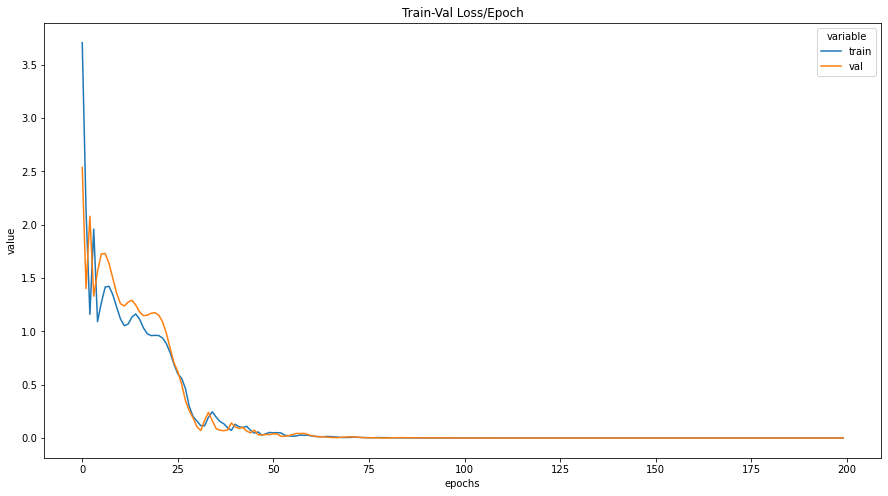

In [449]:
#Visualize Loss and Accuracy
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [450]:
pred_y_list = []

with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        test_y_pred = model(X_batch)
        pred_y_list.append(test_y_pred.cpu().numpy())
pred_y_list = [a.squeeze().tolist() for a in pred_y_list]

In [451]:
mse = mean_squared_error(test_y, pred_y_list)
r_square = r2_score(test_y, pred_y_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.0012048954625251747
R^2 : 0.9982597628871303


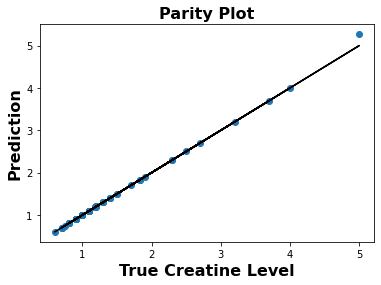

In [452]:
plt.scatter(test_y, pred_y_list)
plt.plot(test_y,test_y,'k-') # identity line
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 16}
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('True Creatine Level', fontdict=font_axis_publish)
plt.ylabel('Prediction', fontdict=font_axis_publish)
plt.show()

In [462]:
mae = mean_absolute_error(test_y, pred_y_list)
print("Mean absolute Error :",mae)

Mean absolute Error : 0.004835316220919289


In [463]:
print(test_y)

[0.6  1.9  1.3  5.   0.9  1.1  1.5  1.   1.   1.83 1.   1.1  0.9  0.8
 4.   1.3  2.3  1.4  1.1  1.2  1.7  1.83 1.1  1.   1.   1.   1.4  0.9
 1.   1.1  2.7  0.9  1.4  1.18 1.2  3.7  1.3  0.9  2.5  0.8  0.7  1.3
 1.18 0.9  1.2  1.2  0.8  1.1  0.75 1.   1.5  3.2  0.7  1.   0.8  2.3
 1.   1.1  1.18 0.7 ]


In [464]:
print(pred_y_list)

[0.5992206931114197, 1.9002594947814941, 1.299753189086914, 5.268850803375244, 0.9003709554672241, 1.0996005535125732, 1.4998843669891357, 0.9996930360794067, 0.9998158812522888, 1.830265760421753, 1.0001156330108643, 1.1002731323242188, 0.9002848863601685, 0.8006906509399414, 3.999767780303955, 1.2998027801513672, 2.300045967102051, 1.3999009132385254, 1.100212574005127, 1.1996662616729736, 1.6987571716308594, 1.8298943042755127, 1.100266933441162, 1.0003280639648438, 0.999553382396698, 1.000410795211792, 1.4004358053207397, 0.899750828742981, 1.0003459453582764, 1.1006335020065308, 2.698521852493286, 0.9008842706680298, 1.4000024795532227, 1.1801135540008545, 1.1996309757232666, 3.699563980102539, 1.2988219261169434, 0.8998833894729614, 2.4996695518493652, 0.8003714084625244, 0.6994197368621826, 1.2999602556228638, 1.1793417930603027, 0.9001645445823669, 1.1997206211090088, 1.1999139785766602, 0.7994904518127441, 1.0995272397994995, 0.7498379945755005, 1.0002331733703613, 1.500405788